In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
np.random.seed(42)

N_PER_USER = 300  # nombre d'échantillons par utilisateur

# Utilisateur A : rapide, temps autour de 200 ms entre touches
t1_A = np.random.normal(loc=0.20, scale=0.03, size=N_PER_USER)
t2_A = np.random.normal(loc=0.18, scale=0.03, size=N_PER_USER)
t3_A = np.random.normal(loc=0.22, scale=0.03, size=N_PER_USER)
T_A  = t1_A + t2_A + t3_A + np.random.normal(loc=0.15, scale=0.02, size=N_PER_USER)

# Utilisateur B : plus lent, temps autour de 400 ms
t1_B = np.random.normal(loc=0.40, scale=0.05, size=N_PER_USER)
t2_B = np.random.normal(loc=0.38, scale=0.05, size=N_PER_USER)
t3_B = np.random.normal(loc=0.42, scale=0.05, size=N_PER_USER)
T_B  = t1_B + t2_B + t3_B + np.random.normal(loc=0.25, scale=0.03, size=N_PER_USER)

# On concatène
X_A = np.stack([t1_A, t2_A, t3_A, T_A], axis=1)
X_B = np.stack([t1_B, t2_B, t3_B, T_B], axis=1)

X = np.vstack([X_A, X_B])
y = np.array([0]*N_PER_USER + [1]*N_PER_USER)  # 0 = A, 1 = B

df = pd.DataFrame(X, columns=["t1", "t2", "t3", "T_total"])
df["user"] = y

df.head()


,t1,t2,t3,T_total,user
0,0.214901,0.155130,0.242710,0.770115,0
1,0.195852,0.163195,0.192335,0.693515,0
2,0.219431,0.202419,0.246088,0.818513,0
3,0.245691,0.198311,0.260669,0.880240,0
4,0.192975,0.179373,0.232403,0.758573,0


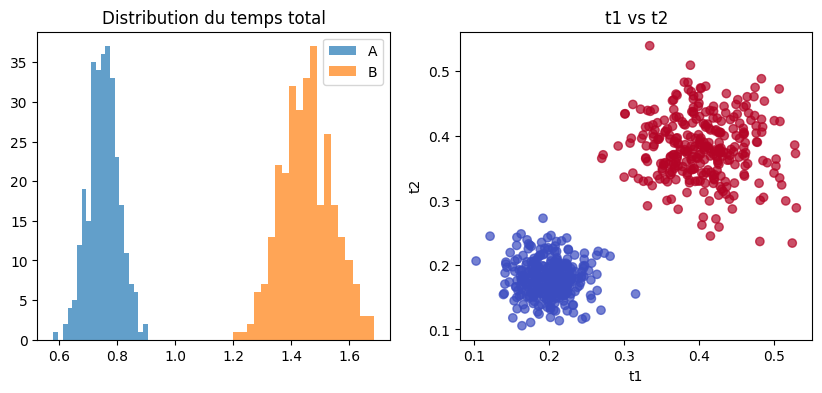

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df[df["user"]==0]["T_total"], bins=20, alpha=0.7, label="A")
plt.hist(df[df["user"]==1]["T_total"], bins=20, alpha=0.7, label="B")
plt.title("Distribution du temps total")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(df["t1"], df["t2"], c=df["user"], cmap="coolwarm", alpha=0.7)
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("t1 vs t2")
plt.show()


In [ ]:
X = df[["t1", "t2", "t3", "T_total"]].values
y = df["user"].values  # 0 ou 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Taille train :", X_train.shape)
print("Taille test  :", X_test.shape)


Taille train : (480, 4)
Taille test  : (120, 4)


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # proba que ce soit user 1 (B)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=40,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

print("Dernière loss train :", history.history["loss"][-1])
print("Dernière acc train  :", history.history["accuracy"][-1])
print("Dernière acc val    :", history.history["val_accuracy"][-1])


Dernière loss train : 0.0013148157158866525
Dernière acc train  : 1.0
Dernière acc val    : 1.0


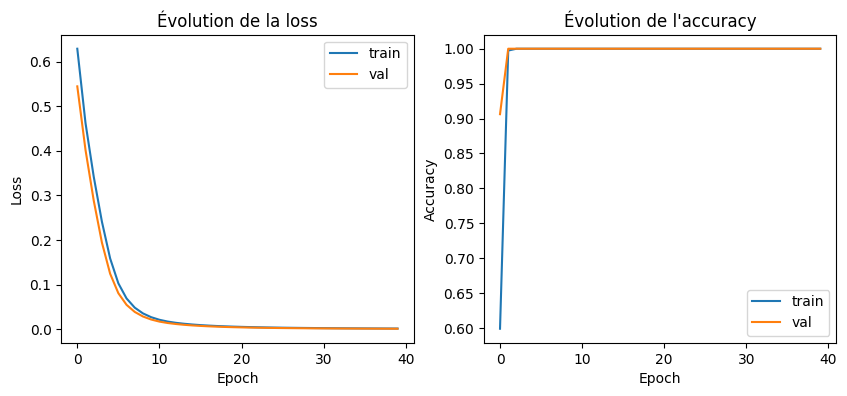

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution de la loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Évolution de l'accuracy")
plt.show()


In [ ]:
# Exemple de frappe "type A"
sample_A = np.array([[0.21, 0.19, 0.23, 0.90]])  # (1,4)
sample_B = np.array([[0.45, 0.40, 0.43, 1.60]])  # (1,4)

sample_A_scaled = scaler.transform(sample_A)
sample_B_scaled = scaler.transform(sample_B)

proba_A = model.predict(sample_A_scaled)[0,0]
proba_B = model.predict(sample_B_scaled)[0,0]

print("Proba user B pour sample_A :", proba_A)
print("Proba user B pour sample_B :", proba_B)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Proba user B pour sample_A : 0.0023228242
Proba user B pour sample_B : 0.9999842


In [ ]:
import time
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# ------------- Paramètres -------------
N_SAMPLES_PER_USER = 5   # nombre de répétitions par utilisateur
PASSWORD_LENGTH = 4      # nombre de chiffres du code

# ------------- Fonction de capture -------------

def capture_sample(user_name):
    """
    Demande à l'utilisateur de taper un code à PASSWORD_LENGTH chiffres.
    Mesure les temps entre chaque chiffre (via time.time() entre les input()).
    Retourne un vecteur [t1, t2, t3, T_total].
    """
    print(f"\n>>> {user_name} : tu vas taper ton code de {PASSWORD_LENGTH} chiffres.")
    print("À CHAQUE chiffre : tape le chiffre PUIS appuie sur ENTREE.")
    input("Appuie sur ENTREE quand tu es prêt...")

    timestamps = []
    digits = []

    for i in range(PASSWORD_LENGTH):
        t0 = time.time()
        d = input(f"Chiffre {i+1} : ")
        t1 = time.time()
        digits.append(d.strip())
        timestamps.append(t1)

    # On calcule les temps entre chiffres
    timestamps = np.array(timestamps)
    t1 = timestamps[1] - timestamps[0]
    t2 = timestamps[2] - timestamps[1]
    t3 = timestamps[3] - timestamps[2]
    T_total = timestamps[3] - timestamps[0]

    print(f"Temps mesurés : t1={t1:.3f}s, t2={t2:.3f}s, t3={t3:.3f}s, T_total={T_total:.3f}s")

    return np.array([t1, t2, t3, T_total], dtype=float)

# ------------- Collecte des données -------------

X = []
y = []

print("On va d'abord enregistrer les exemples pour UTILISATEUR 1.")
for i in range(N_SAMPLES_PER_USER):
    print(f"\n--- Essai {i+1} / {N_SAMPLES_PER_USER} pour Utilisateur 1 ---")
    feat = capture_sample("Utilisateur 1")
    X.append(feat)
    y.append(0)   # label 0 pour user 1

print("\n==========================================")
print("Maintenant on passe à UTILISATEUR 2.")
print("==========================================\n")

for i in range(N_SAMPLES_PER_USER):
    print(f"\n--- Essai {i+1} / {N_SAMPLES_PER_USER} pour Utilisateur 2 ---")
    feat = capture_sample("Utilisateur 2")
    X.append(feat)
    y.append(1)   # label 1 pour user 2

X = np.vstack(X)
y = np.array(y)

print("\nDonnées collectées :")
print("X shape :", X.shape)
print("y :", y)

# ------------- Normalisation + entraînement -------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(8,), activation="relu",
                    max_iter=2000, random_state=0)
print("\nEntraînement du modèle...")
clf.fit(X_scaled, y)
print("Entraînement terminé.")

# ------------- Test interactif -------------

print("\n================ TEST ================")
print("Maintenant, tape le même code comme tu veux (User 1 ou 2).")
print("Le modèle va essayer de deviner qui tu es.\n")

test_feat = capture_sample("Test")
test_feat_scaled = scaler.transform(test_feat.reshape(1, -1))

proba = clf.predict_proba(test_feat_scaled)[0]
pred = clf.predict(test_feat_scaled)[0]

if pred == 0:
    user_pred = "UTILISATEUR 1"
else:
    user_pred = "UTILISATEUR 2"

print("\nRésultat du modèle :")
print(f"Probabilité User1 = {proba[0]:.3f}, Probabilité User2 = {proba[1]:.3f}")
print(f"→ Je pense que c'est : {user_pred}")
11235
31

On va d'abord enregistrer les exemples pour UTILISATEUR 1.

--- Essai 1 / 5 pour Utilisateur 1 ---

>>> Utilisateur 1 : tu vas taper ton code de 4 chiffres.
À CHAQUE chiffre : tape le chiffre PUIS appuie sur ENTREE.
Appuie sur ENTREE quand tu es prêt...1
Chiffre 1 : 1
Chiffre 2 : 2
Chiffre 3 : 3
Chiffre 4 : 4
Temps mesurés : t1=2.109s, t2=2.102s, t3=2.371s, T_total=6.582s

--- Essai 2 / 5 pour Utilisateur 1 ---

>>> Utilisateur 1 : tu vas taper ton code de 4 chiffres.
À CHAQUE chiffre : tape le chiffre PUIS appuie sur ENTREE.
Appuie sur ENTREE quand tu es prêt...1
Chiffre 1 : 2
Chiffre 2 : 3
Chiffre 3 : 4
Chiffre 4 : 1
Temps mesurés : t1=1.249s, t2=2.180s, t3=1.993s, T_total=5.423s

--- Essai 3 / 5 pour Utilisateur 1 ---

>>> Utilisateur 1 : tu vas taper ton code de 4 chiffres.
À CHAQUE chiffre : tape le chiffre PUIS appuie sur ENTREE.
Appuie sur ENTREE quand tu es prêt...1
Chiffre 1 : 1
Chiffre 2 : 1
Chiffre 3 : 1
Chiffre 4 : 1
Temps mesurés : t1=1.403s, t2=1.247s, t3=0.900s, T_total=

KeyboardInterrupt: Interrupted by user

In [ ]:
df = pd.DataFrame(X, columns=["t1", "t2", "t3", "T_total"])
df["user"] = y


In [ ]:
print("X:", type(X))
print("y:", type(y))
try:
    print("X shape:", X.shape)
    print("y shape:", y.shape)
except Exception as e:
    print("Erreur shape:", e)


X: <class 'numpy.ndarray'>
y: <class 'numpy.ndarray'>
X shape: (10, 4)
y shape: (10,)


In [ ]:
X = df[["t1", "t2", "t3", "T_total"]].values
y = df["user"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaler entraîné sur", X.shape[0], "échantillons.")


Scaler entraîné sur 10 échantillons.


In [ ]:
mean = scaler.mean_
std = scaler.scale_

print("mean:", mean)
print("std :", std)


mean: [2.3825485  4.64769619 2.58439498 9.61463966]
std : [1.64093608 5.72693257 1.19937432 7.41552933]


In [ ]:
def to_c_array(name, arr):
    return "float " + name + "[" + str(len(arr)) + "] = { " + \
           ", ".join(f"{v:.6f}f" for v in arr) + " };"

print(to_c_array("feature_mean", mean))
print(to_c_array("feature_std", std))


float feature_mean[4] = { 2.382548f, 4.647696f, 2.584395f, 9.614640f };
float feature_std[4] = { 1.640936f, 5.726933f, 1.199374f, 7.415529f };
